In [58]:
import numpy as np
import matplotlib.pyplot as plt
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy.table import Table, vstack

In [35]:
# Set the global font size
plt.rcParams['font.size'] = 14

In [36]:
# Define parameters for the query
# Define the center position and box size
ra_center, dec_center = 180.0, 0.0  # Center position in degrees
box_size = 4.0  # Box size in degrees

# Calculate RA and Dec range
ra1, ra2 = ra_center - box_size / 2, ra_center + box_size / 2
dec1, dec2 = dec_center - box_size / 2, dec_center + box_size / 2

psfmag_r_limit = 23  # Magnitude limit for r-band

# Query SDSS using SQL
print('Querying SDSS...')
sdss_query = f"""
    SELECT ra, dec, psfMag_r, modelMag_r
    FROM PhotoTag
    WHERE type = 6 AND mode = 1
    AND ra BETWEEN {ra1} AND {ra2}
    AND dec BETWEEN {dec1} AND {dec2}
    AND psfMag_r < {psfmag_r_limit}
"""
sdss_results = SDSS.query_sql(sdss_query, cache=False, timeout=3600)

# Query Gaia using SQL
print('Querying Gaia...')
gaia_query = f"""
    SELECT source_id, ra, dec, pmra, pmdec, pmra_error, pmdec_error, parallax_over_error
    FROM gaiadr3.gaia_source
    WHERE ra BETWEEN {ra1} AND {ra2}
    AND dec BETWEEN {dec1} AND {dec2}
"""
job = Gaia.launch_job_async(gaia_query)
gaia_results = job.get_results()

Querying SDSS...
Querying Gaia...
INFO: Query finished. [astroquery.utils.tap.core]


Cross-mtaching...


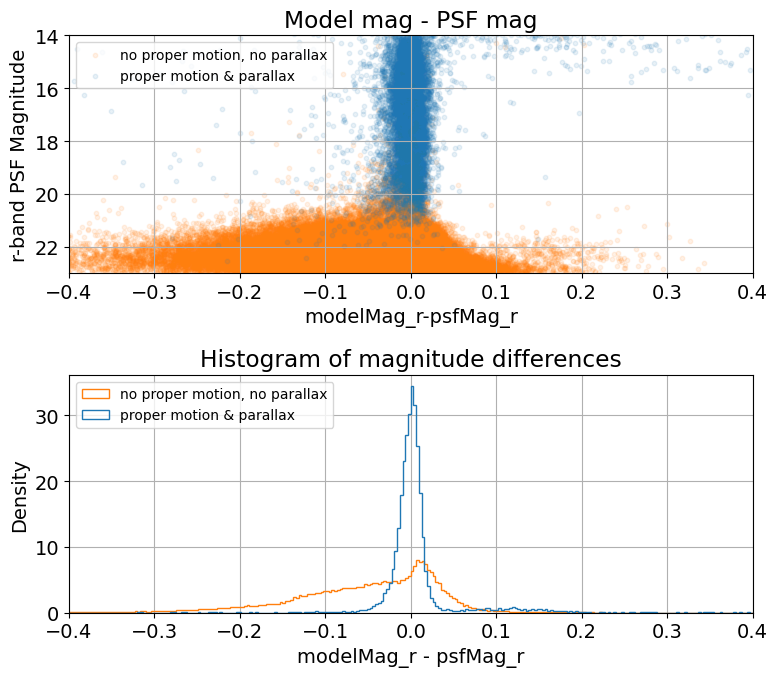

In [85]:
# Setup
magdif_range = np.array([-0.4, 0.4])
nbins = 250

# Cross-match the results
print('Cross-mtaching...')
# Cross-match the results
sdss_coords = SkyCoord(ra=sdss_results['ra'], dec=sdss_results['dec'], unit='deg')
gaia_coords = SkyCoord(ra=gaia_results['ra'], dec=gaia_results['dec'], unit='deg')
idx, d2d, d3d = sdss_coords.match_to_catalog_sky(gaia_coords)

# Filter out invalid indices
valid_matches = d2d < 1.5 * u.arcsec  # Ensure matches are within 1 arcsecond
matched_sdss = sdss_results[valid_matches]
matched_gaia = gaia_results[idx[valid_matches]]

# Add proper motion flag
# Threshold for significant proper motion
pm = np.sqrt(matched_gaia['pmra']**2 + matched_gaia['pmdec']**2)
pm_err = np.sqrt(matched_gaia['pmra_error']**2 + matched_gaia['pmdec_error']**2)
proper_motion_parallax = (pm/pm_err > 10) & (matched_gaia['parallax_over_error']>5) 
no_proper_motion_parallax = (pm/pm_err < 1) & (matched_gaia['parallax_over_error']<1)


# Include unmatched SDSS objects in the no_proper_motion_parallax category
unmatched_indices = ~valid_matches
unmatched_sdss = sdss_results[unmatched_indices]

# Combine matched and unmatched for no proper motion
matched_sdss['proper_motion_parallax'] = proper_motion_parallax
matched_sdss['no_proper_motion_parallax'] = no_proper_motion_parallax
unmatched_sdss['proper_motion_parallax'] = np.full(len(unmatched_sdss), False)
unmatched_sdss['no_proper_motion_parallax'] = np.full(len(unmatched_sdss), True)

# Merge tables
final_sdss = vstack([matched_sdss, unmatched_sdss])

# Plotting the difference between g-band and r-band PSF magnitudes as a function of r-band magnitude
mag_difference = final_sdss['modelMag_r'] - final_sdss['psfMag_r']
r_mag = final_sdss['psfMag_r']

# Separate data by proper motion
has_proper_motion = final_sdss['proper_motion_parallax']
no_proper_motion = final_sdss['no_proper_motion_parallax']


plt.figure(figsize=(8, 7))

# Top plot: Scatter plot of magnitude difference vs r-band magnitude
plt.subplot(2, 1, 1)
plt.scatter(mag_difference[no_proper_motion], r_mag[no_proper_motion], s=10, c='tab:orange',
            label='no proper motion, no parallax', alpha=0.1)
plt.scatter(mag_difference[has_proper_motion], r_mag[has_proper_motion], s=10, c='tab:blue', 
            label='proper motion & parallax', alpha=0.1)

plt.xlim(magdif_range)
plt.ylim(23, 14)
plt.ylabel('r-band PSF Magnitude')
plt.xlabel('modelMag_r-psfMag_r')
plt.title('Model mag - PSF mag')
plt.legend(loc='upper left', fontsize=10)
plt.grid()

# Bottom plot: Histogram of magnitude differences (unfilled)
plt.subplot(2, 1, 2)
plt.hist(mag_difference[no_proper_motion], bins=nbins, range=magdif_range, histtype='step', color='tab:orange', 
         label='no proper motion, no parallax', density=True)
plt.hist(mag_difference[has_proper_motion], bins=nbins, range=magdif_range, histtype='step', color='tab:blue', 
         label='proper motion & parallax', density=True)

plt.xlim(magdif_range)
plt.xlabel('modelMag_r - psfMag_r')
plt.ylabel('Density')
plt.title('Histogram of magnitude differences')
plt.grid()
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('plots/star_galaxy_gaia_sdss.png', bbox_inches='tight', facecolor='white')
plt.show()